# Задание 5-6: Разработка knn-, SVM-, RF-классификаторов
Выполнено студенткой группы ИММО-01-25 Чан Минь Ханг

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report, confusion_matrix
from sklearn.manifold import TSNE
import umap
import trimap
import pacmap
from sklearn.tree import plot_tree
import warnings
warnings.filterwarnings('ignore')

*Набор данных: https://archive.ics.uci.edu/dataset/104/university*

In [2]:
df = pd.read_csv('university.csv')
df

name          state                 control  \
0                    ADELPHI        NEWYORK                 PRIVATE   
1              ARIZONA-STATE        ARIZONA                   STATE   
2             BOSTON-COLLEGE  MASSACHUSETTS  PRIVATE:ROMAN-CATHOLIC   
3          BOSTON-UNIVERSITY  MASSACHUSETTS                 PRIVATE   
4                      BROWN    RHODEISLAND                 PRIVATE   
..                       ...            ...                     ...   
280  ORAL-ROBERTS-UNIVERSITY       OKLAHOMA                 PRIVATE   
281      UNIVERSITY-OF-TULSA       OKLAHOMA                 PRIVATE   
282      CONNECTICUT-COLLEGE    CONNECTICUT                 PRIVATE   
283        LEHIGH-UNIVERSITY   PENNSYLVANIA                 PRIVATE   
284             OREGON-STATE         OREGON                   STATE   

    no_of_students male:female_ratio student:faculty_ratio  sat_verbal  \
0           0-5000             30:70                  15:1       500.0   
1           20000+             50:50                  20:1       450.0   
2           0-5000             40:60                  20:1       500.0   
3      10000-15000             45:55                  12:1       550.0   
4           0-5000             50:50                  11:1       625.0   
..             ...               ...                   ...         ...   
280         0-5000               1:1                  11:1       463.0   
281         0-5000               3:2                  16:1       471.0   
282         0-5000             35:65                  10:1       550.0   
283         0-5000             75:25                  10:1       550.0   
284    15000-20000             80:60                  17:1         NaN   

     sat_math    expenses  percent_financial_aid  ... percent_admittance  \
0       475.0  7000-10000                   60.0  ...               70.0   
1       500.0      0-4000                   50.0  ...               80.0   
2       550.0      10000+                   60.0  ...               50.0   
3       575.0      10000+                   60.0  ...               60.0   
4       650.0      10000+                   40.0  ...               20.0   
..        ...         ...                    ...  ...                ...   
280     490.0      0-4000                   70.0  ...               65.0   
281     520.0      0-4000                   75.0  ...               85.0   
282     575.0      10000+                   30.0  ...               40.0   
283     650.0  7000-10000                   45.0  ...               50.0   
284       NaN      0-4000                   65.0  ...               90.0   

     percent_enrolled  academics_scale  social_scale  quality_of_life_scale  \
0                40.0              2.0           2.0                    2.0   
1                60.0              3.0           4.0                    5.0   
2                40.0              4.0           5.0                    3.0   
3                40.0              4.0           4.0                    3.0   
4                50.0              5.0           4.0                    5.0   
..                ...              ...           ...                    ...   
280              75.0              4.0           2.0                    3.0   
281              65.0              4.0           4.0                    4.0   
282              40.0              4.0           3.0                    4.0   
283              40.0              4.0           4.0                    2.0   
284              70.0              3.0           4.0                    2.0   

                                     academic_emphasis    location colors  \
0                     business-administration, biology         NaN    NaN   
1    business-education, engineering, accounting, f...         NaN    NaN   
2                          economics, biology, english    SUBURBAN    NaN   
3    business-administration, psychology, liberal-arts       URBAN    NaN   
4                      biology, his

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285 entries, 0 to 284
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   name                   285 non-null    object 
 1   state                  285 non-null    object 
 2   control                282 non-null    object 
 3   no_of_students         285 non-null    object 
 4   male:female_ratio      285 non-null    object 
 5   student:faculty_ratio  263 non-null    object 
 6   sat_verbal             263 non-null    float64
 7   sat_math               263 non-null    float64
 8   expenses               285 non-null    object 
 9   percent_financial_aid  273 non-null    float64
 10  no_applicants          279 non-null    object 
 11  percent_admittance     280 non-null    float64
 12  percent_enrolled       281 non-null    float64
 13  academics_scale        277 non-null    float64
 14  social_scale           277 non-null    float64
 15  qualit

In [4]:
target = 'academics_scale'
print("Целевая переменная:", target)
print("Количество классов:", df[target].nunique())
print("Распределение классов:")
print(df[target].value_counts().sort_index())

df = df.dropna(subset=[target])

Целевая переменная: academics_scale
Количество классов: 5
Распределение классов:
1.0     7
2.0    33
3.0    99
4.0    95
5.0    43
Name: academics_scale, dtype: int64


In [5]:
text_cols = ['name', 'state', 'control', 'location', 'colors', 
             'mascot', 'religious_backing', 'academic_emphasis']
df = df.drop(columns=[col for col in text_cols if col in df.columns], 
             errors='ignore')

categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
for col in categorical_cols:
    if col in df.columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))
        
X = df.drop(columns=[target])
y = df[target]

imputer = SimpleImputer(strategy='median')
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, 
                                                    random_state=42, stratify=y)
print(f"\nРазмеры выборок:")
print(f"\tОбучающая: {X_train.shape}")
print(f"\tТестовая:  {X_test.shape}")
print(f"\nРаспределение классов в обучающей выборке:")
print(pd.Series(y_train).value_counts().sort_index())
print(f"\nРаспределение классов в тестовой выборке:")
print(pd.Series(y_test).value_counts().sort_index())


Размеры выборок:
	Обучающая: (221, 12)
	Тестовая:  (56, 12)

Распределение классов в обучающей выборке:
1.0     6
2.0    26
3.0    79
4.0    76
5.0    34
Name: academics_scale, dtype: int64

Распределение классов в тестовой выборке:
1.0     1
2.0     7
3.0    20
4.0    19
5.0     9
Name: academics_scale, dtype: int64


In [6]:
def evaluate_model(y_true, y_pred, model_name=""):
    acc = accuracy_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    prec = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    print(f"{model_name}:")
    print(f"  Accuracy:  {acc:.4f}")
    print(f"  Recall:    {rec:.4f}")
    print(f"  Precision: {prec:.4f}")
    print(f"  F1-score:  {f1:.4f}")
    print(classification_report(y_true, y_pred, zero_division=0))
    
    cm = confusion_matrix(y_true, y_pred)
    unique_labels = np.unique(np.concatenate([y_true, y_pred]))
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=unique_labels,
                yticklabels=unique_labels)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    return acc, rec, prec, f1

In [7]:
def visualize(X_data, y_true, y_pred, model_name, support_vectors_idx=None):
    reducers = {
        't-SNE': [
            {'n_components': 2, 'perplexity': 5, 'learning_rate': 200},
            {'n_components': 2, 'perplexity': 15, 'learning_rate': 200},
            {'n_components': 2, 'perplexity': 30, 'learning_rate': 200}
        ],
        'UMAP': [
            {'n_components': 2, 'n_neighbors': 5, 'min_dist': 0.1},
            {'n_components': 2, 'n_neighbors': 15, 'min_dist': 0.1},
            {'n_components': 2, 'n_neighbors': 30, 'min_dist': 0.1}
        ],
        'TriMAP': [
            {'n_dims': 2, 'n_inliers': 10, 'n_outliers': 5},
            {'n_dims': 2, 'n_inliers': 20, 'n_outliers': 10},
            {'n_dims': 2, 'n_inliers': 30, 'n_outliers': 15}
        ],
        'PaCMAP': [
            {'n_components': 2, 'n_neighbors': 10, 'MN_ratio': 0.5, 'FP_ratio': 2.0},
            {'n_components': 2, 'n_neighbors': 20, 'MN_ratio': 0.5, 'FP_ratio': 2.0},
            {'n_components': 2, 'n_neighbors': 10, 'MN_ratio': 0.8, 'FP_ratio': 2.0}
        ]
    }
    
    unique_classes = np.unique(np.concatenate([y_true, y_pred]))
    num_classes = len(unique_classes)

    colors = ['#FF0000', '#FF5500', '#FFAA00', '#AAFF00', '#00FF00']  
    cmap_gradient = ListedColormap(colors)
    
    for method_name, param_combinations in reducers.items():
        num_combinations = len(param_combinations)
        fig, axes = plt.subplots(2, num_combinations, figsize=(5*num_combinations, 10))

        for i, params in enumerate(param_combinations):
            try:
                if method_name == 't-SNE':
                    reducer = TSNE(**params, random_state=42)
                elif method_name == 'UMAP':
                    reducer = umap.UMAP(**params, random_state=42)
                elif method_name == 'TriMAP':
                    reducer = trimap.TRIMAP(**params)
                elif method_name == 'PaCMAP':
                    reducer = pacmap.PaCMAP(**params)
                else:
                    continue

                # Применяем редукцию
                X_emb = reducer.fit_transform(X_data)

                # Истинные метки
                ax1 = axes[0, i] if num_combinations > 1 else axes[0]
                param_title = '\n'.join([f"{key} = {value}" 
                                         for key, value in params.items()])
                scatter1 = ax1.scatter(X_emb[:, 0], X_emb[:, 1], c=y_true, 
                                       cmap=cmap_gradient, alpha=0.7, s=50,
                                       vmin=min(unique_classes)-0.5, 
                                       vmax=max(unique_classes)+0.5)
                ax1.set_title(param_title)
                ax1.set_xlabel("Component 1")
                ax1.set_ylabel("Component 2")
                plt.colorbar(scatter1, ax=ax1)

                # Предсказанные метки
                ax2 = axes[1, i] if num_combinations > 1 else axes[1]
                scatter2 = ax2.scatter(X_emb[:, 0], X_emb[:, 1], c=y_pred,
                                       cmap=cmap_gradient, alpha=0.7, s=50,
                                       vmin=min(unique_classes)-0.5, 
                                       vmax=max(unique_classes)+0.5)
                ax2.set_title("Предсказания")
                ax2.set_xlabel("Component 1")
                ax2.set_ylabel("Component 2")
                plt.colorbar(scatter2, ax=ax2)

                # Опорные векторы (если есть)
                if support_vectors_idx is not None and len(support_vectors_idx) > 0:
                    sv_indices_in_emb = [idx for idx 
                                         in support_vectors_idx if idx < len(X_emb)]
                    if sv_indices_in_emb:
                        support_vectors_emb = X_emb[sv_indices_in_emb, :]
                        ax1.scatter(support_vectors_emb[:, 0], 
                                    support_vectors_emb[:, 1], 
                                    s=150, facecolors='none', 
                                    edgecolors='red', linewidths=1, 
                                    label=f'Опорные векторы ({len(sv_indices_in_emb)})')
                        ax2.scatter(support_vectors_emb[:, 0], 
                                    support_vectors_emb[:, 1], 
                                    s=150, facecolors='none', 
                                    edgecolors='red', linewidths=1, 
                                    label=f'Опорные векторы ({len(sv_indices_in_emb)})')
                        ax1.legend()
                        ax2.legend()

            except Exception as e:
                print(f"Ошибка при визуализации с параметрами {params}: {e}")

        plt.suptitle(f"\nВизуализация {model_name} с помощью {method_name}", 
                     fontsize=16, fontweight='bold', y=1.02)
        plt.tight_layout()
        plt.show()

## Часть А. Разработать SVM-классификатор

Разбить выборку на обучающую и тестовую. 

Обучить, проверить качество классификатора на обучающей и тестовой выборках: рассчитать общую точность, Recall, Precision, F1-measure. 

Оценить число опорных векторов. 

Рассмотреть различные типы ядра (линейное, RBF, полиномиальное, сигмоидное (тангенсальное)), различные сочетания значений параметра регуляризации С и параметров ядра. Перебор по сетке (grid search). 

Выбрать лучший классификатор. 

Выполнить визуализацию с помощью t-sne, UMAP, TriMAP и PacMAP (при различных сочетаниях значений их параметров): изобразить объекты разных классов и опорные векторы разных классов разным цветом (разным маркерами). 

Сделать рисунки разбиения на классы на основе выборок с известными метками классов и рисунки разбиения на классы с метками выставленными классификатором. 

In [8]:
param_grid_svm = {
    'C': [0.001, 0.01, 0.1, 0.5],
    'kernel': ['linear', 'rbf'],
    'gamma': [0.01, 0.05, 0.1, 'scale']
}

svm = SVC(random_state=42, probability=True)
grid_svm = GridSearchCV(svm, param_grid_svm, cv=3, 
                        scoring='f1_weighted', n_jobs=-1)
grid_svm.fit(X_train, y_train)

best_svm = grid_svm.best_estimator_
print(f"Лучшие параметры SVM: {grid_svm.best_params_}")

Лучшие параметры SVM: {'C': 0.5, 'gamma': 0.01, 'kernel': 'linear'}



Оценка на обучающей выборке:
SVM Train:
  Accuracy:  0.6516
  Recall:    0.6516
  Precision: 0.6552
  F1-score:  0.6515
              precision    recall  f1-score   support

         1.0       0.67      0.33      0.44         6
         2.0       0.50      0.58      0.54        26
         3.0       0.65      0.66      0.65        79
         4.0       0.65      0.64      0.65        76
         5.0       0.79      0.76      0.78        34

    accuracy                           0.65       221
   macro avg       0.65      0.60      0.61       221
weighted avg       0.66      0.65      0.65       221



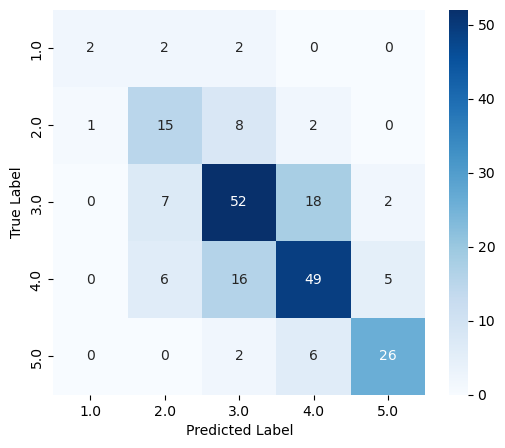


Оценка на тестовой выборке:
SVM Test:
  Accuracy:  0.4643
  Recall:    0.4643
  Precision: 0.4587
  F1-score:  0.4515
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         1
         2.0       0.17      0.14      0.15         7
         3.0       0.44      0.60      0.51        20
         4.0       0.54      0.37      0.44        19
         5.0       0.60      0.67      0.63         9

    accuracy                           0.46        56
   macro avg       0.35      0.36      0.35        56
weighted avg       0.46      0.46      0.45        56



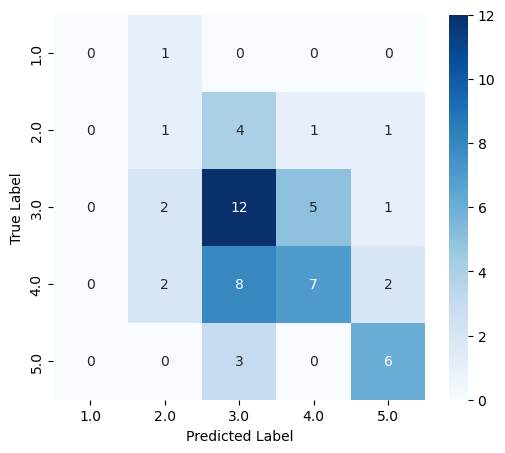

In [9]:
y_train_pred_svm = best_svm.predict(X_train)
print("\nОценка на обучающей выборке:")
train_metrics_svm = evaluate_model(y_train, y_train_pred_svm, "SVM Train")

y_test_pred_svm = best_svm.predict(X_test)
print("\nОценка на тестовой выборке:")
test_metrics_svm = evaluate_model(y_test, y_test_pred_svm, "SVM Test")

In [10]:
print(f"Количество опорных векторов: {best_svm.support_.shape[0]}")

Количество опорных векторов: 196


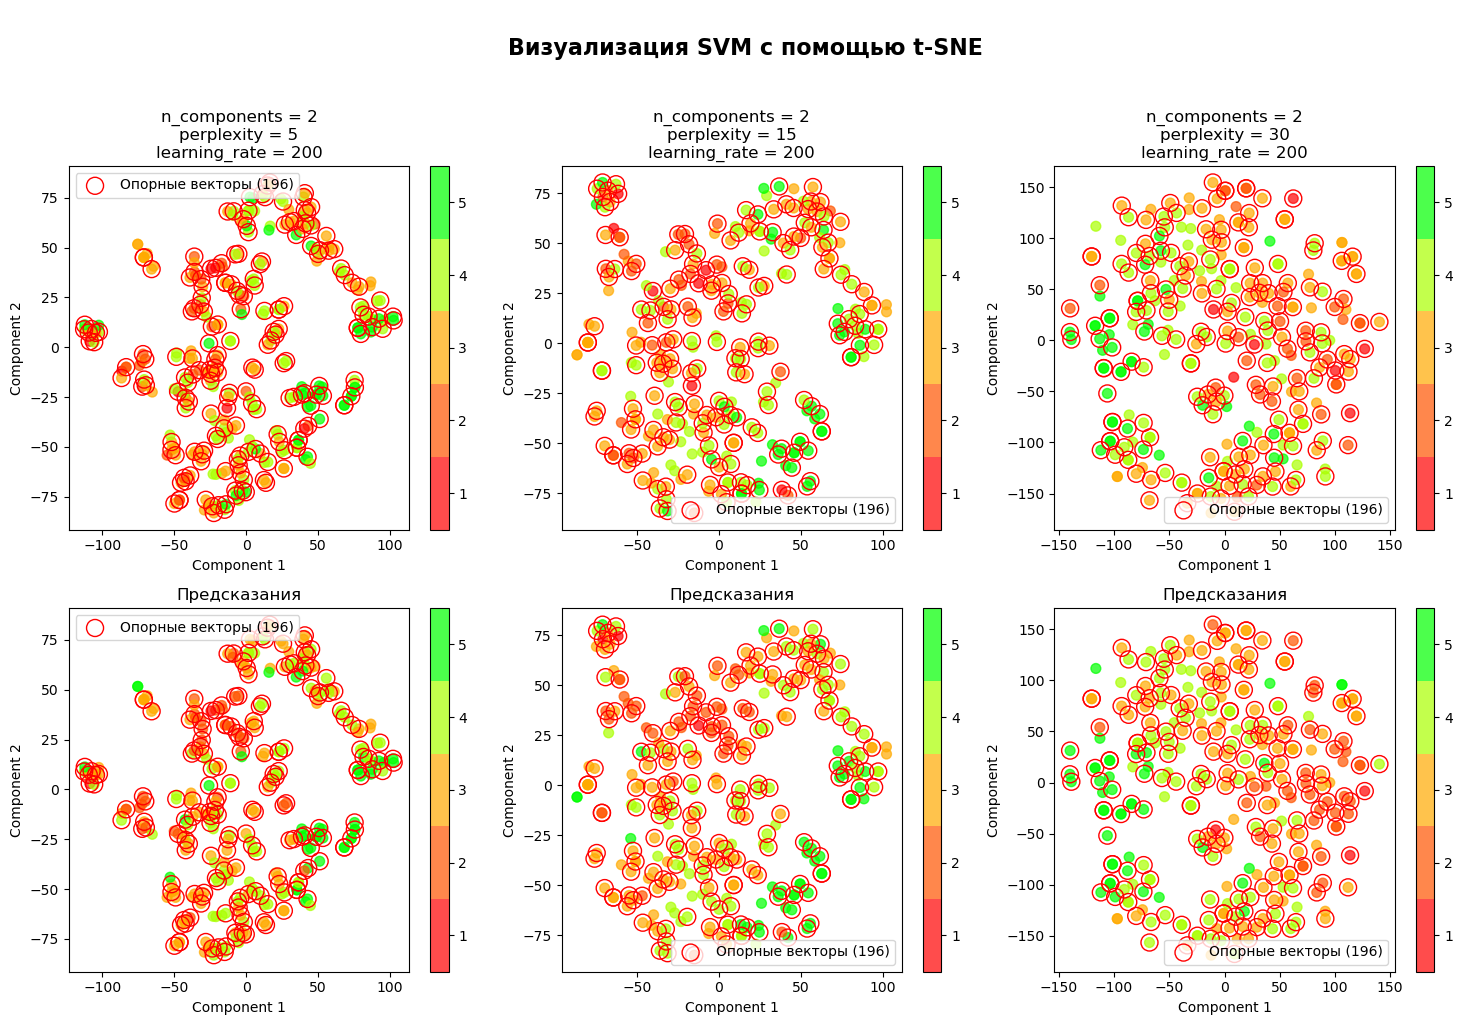

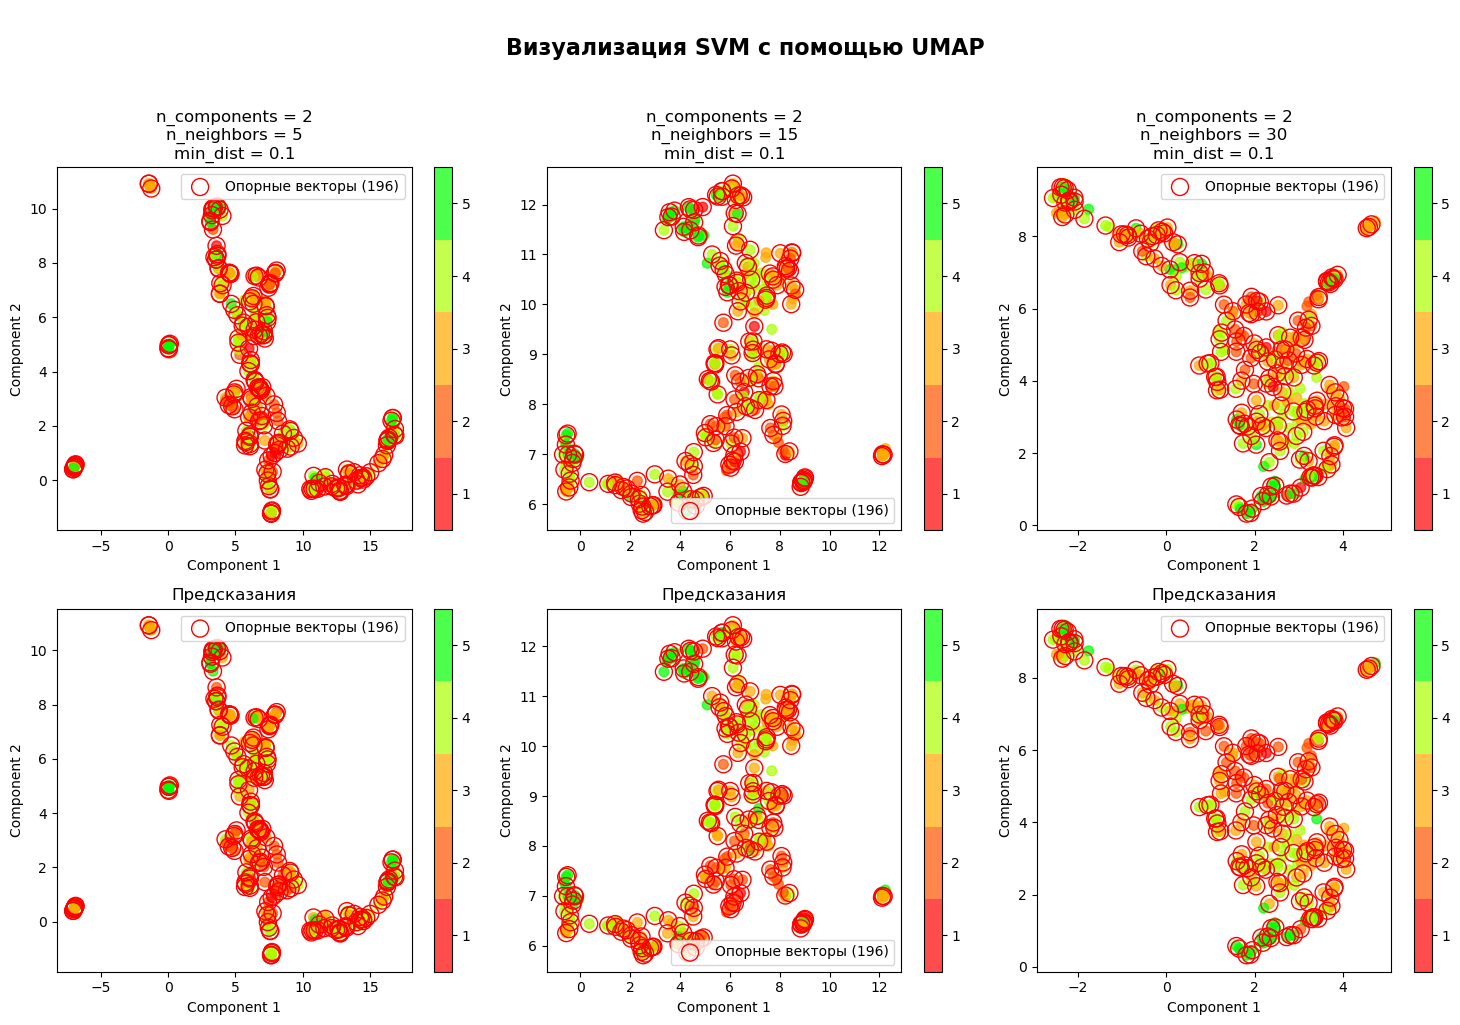

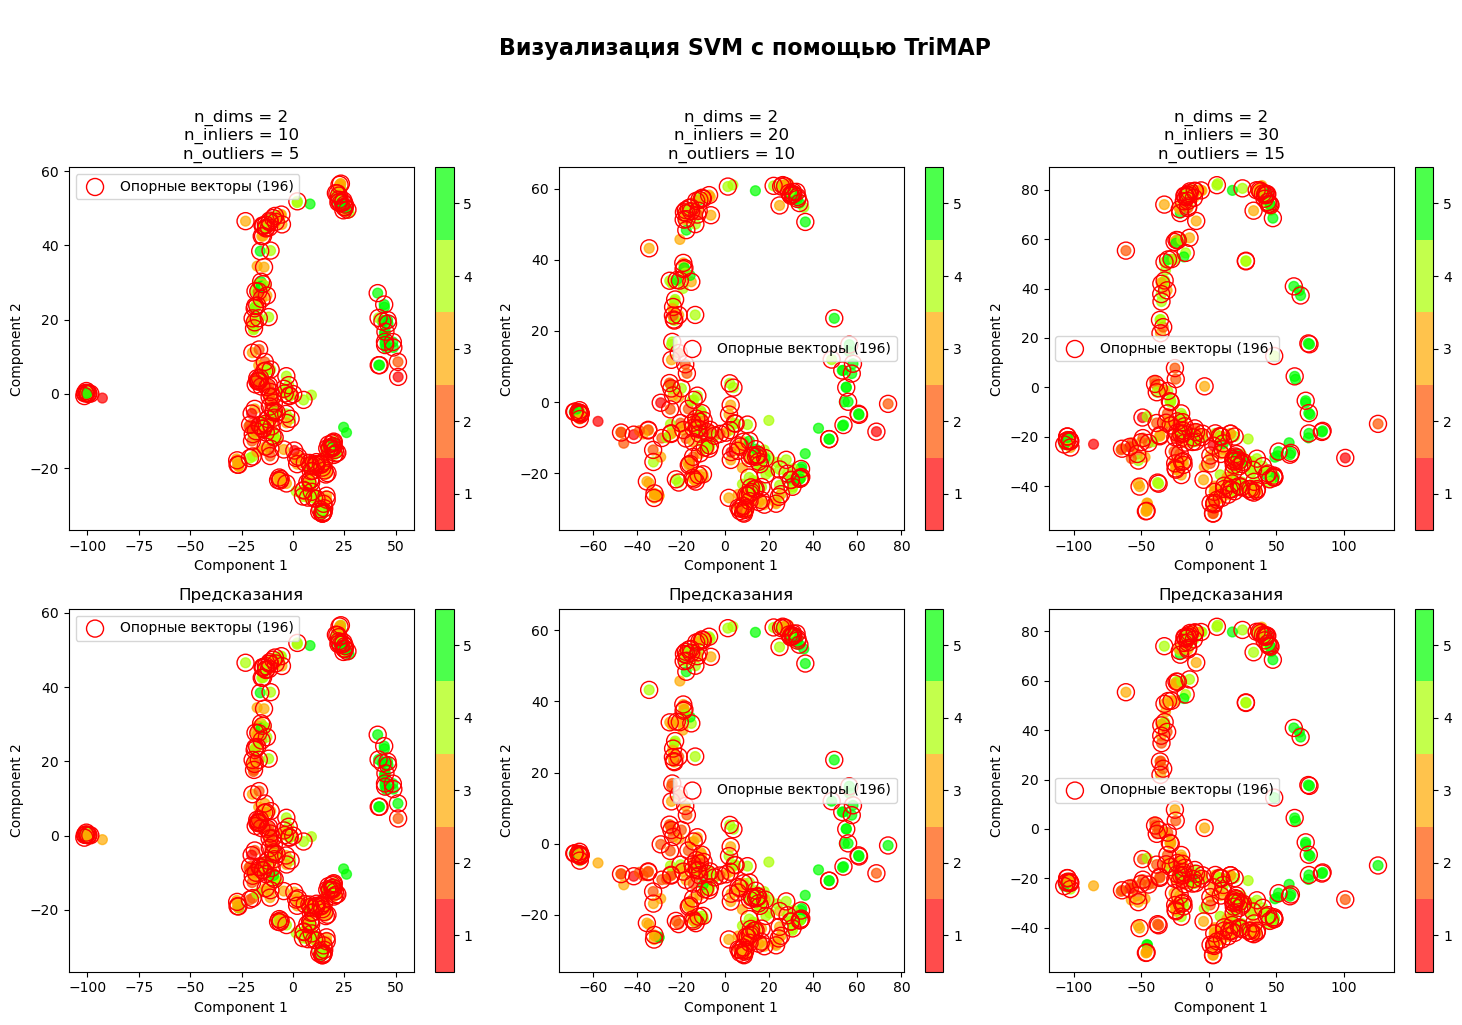

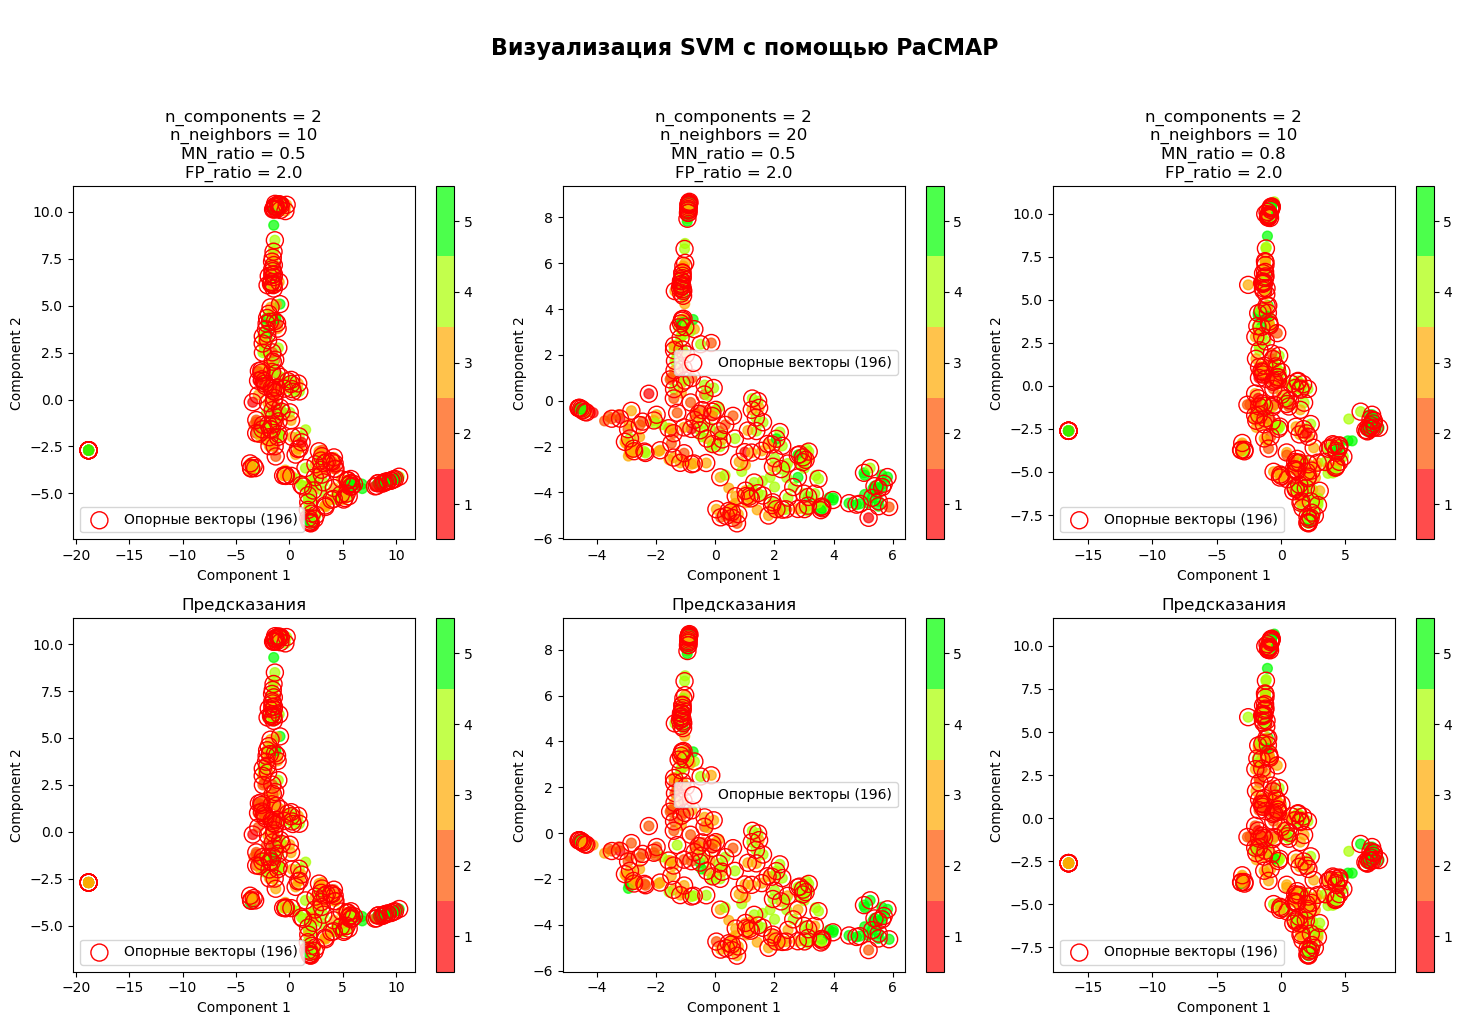

In [11]:
y_all_pred_svm = best_svm.predict(X_scaled)

visualize(X_scaled, y, y_all_pred_svm, "SVM", best_svm.support_)

## Часть B. Разработать knn-классификатор

Разбить выборку на обучающую и тестовую. 

Обучить, проверить качество классификатора на обучающей и тестовой 
выборках: рассчитать общую точность, Recall, Precision, F1-measure. 

Рассмотреть различное число ближайших соседей, различные метрики 
для вычисления расстояний между объектами, различные правила 
голосования. Перебор по сетке (grid search). 

Выбрать лучший классификатор. 

Выполнить визуализацию с помощью t-sne, UMAP, TriMAP и PacMAP 
(при различных сочетаниях значений их параметров): изобразить объекты 
разных классов разным цветом (разным маркерами). 

Сделать рисунки разбиения на классы на основе выборок с известными 
метками классов и рисунки разбиения на классы с метками выставленными 
классификатором. 

In [12]:
param_grid_knn = {
    'n_neighbors': [5, 7, 9, 11, 13, 15, 17, 20, 25, 30],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

knn = KNeighborsClassifier()
grid_knn = GridSearchCV(knn, param_grid_knn, cv=3, 
                        scoring='f1_weighted', n_jobs=-1)
grid_knn.fit(X_train, y_train)

best_knn = grid_knn.best_estimator_
print(f"Лучшие параметры KNN: {grid_knn.best_params_}")

Лучшие параметры KNN: {'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'distance'}



Оценка на обучающей выборке:
KNN Train:
  Accuracy:  1.0000
  Recall:    1.0000
  Precision: 1.0000
  F1-score:  1.0000
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00         6
         2.0       1.00      1.00      1.00        26
         3.0       1.00      1.00      1.00        79
         4.0       1.00      1.00      1.00        76
         5.0       1.00      1.00      1.00        34

    accuracy                           1.00       221
   macro avg       1.00      1.00      1.00       221
weighted avg       1.00      1.00      1.00       221



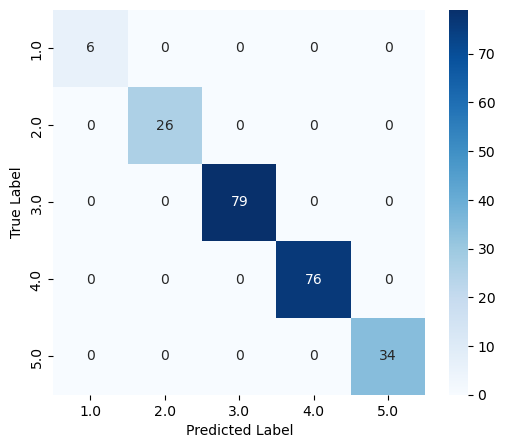


Оценка на тестовой выборке:
KNN Test:
  Accuracy:  0.6429
  Recall:    0.6429
  Precision: 0.6280
  F1-score:  0.6286
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         1
         2.0       0.50      0.29      0.36         7
         3.0       0.60      0.75      0.67        20
         4.0       0.67      0.63      0.65        19
         5.0       0.78      0.78      0.78         9

    accuracy                           0.64        56
   macro avg       0.51      0.49      0.49        56
weighted avg       0.63      0.64      0.63        56



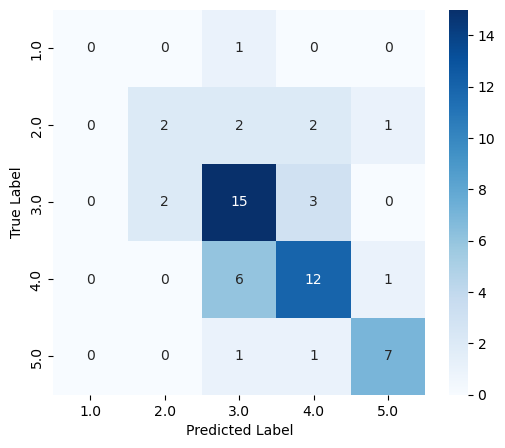

In [13]:
y_train_pred_knn = best_knn.predict(X_train)
print("\nОценка на обучающей выборке:")
train_metrics_knn = evaluate_model(y_train, y_train_pred_knn, "KNN Train")

y_test_pred_knn = best_knn.predict(X_test)
print("\nОценка на тестовой выборке:")
test_metrics_knn = evaluate_model(y_test, y_test_pred_knn, "KNN Test")

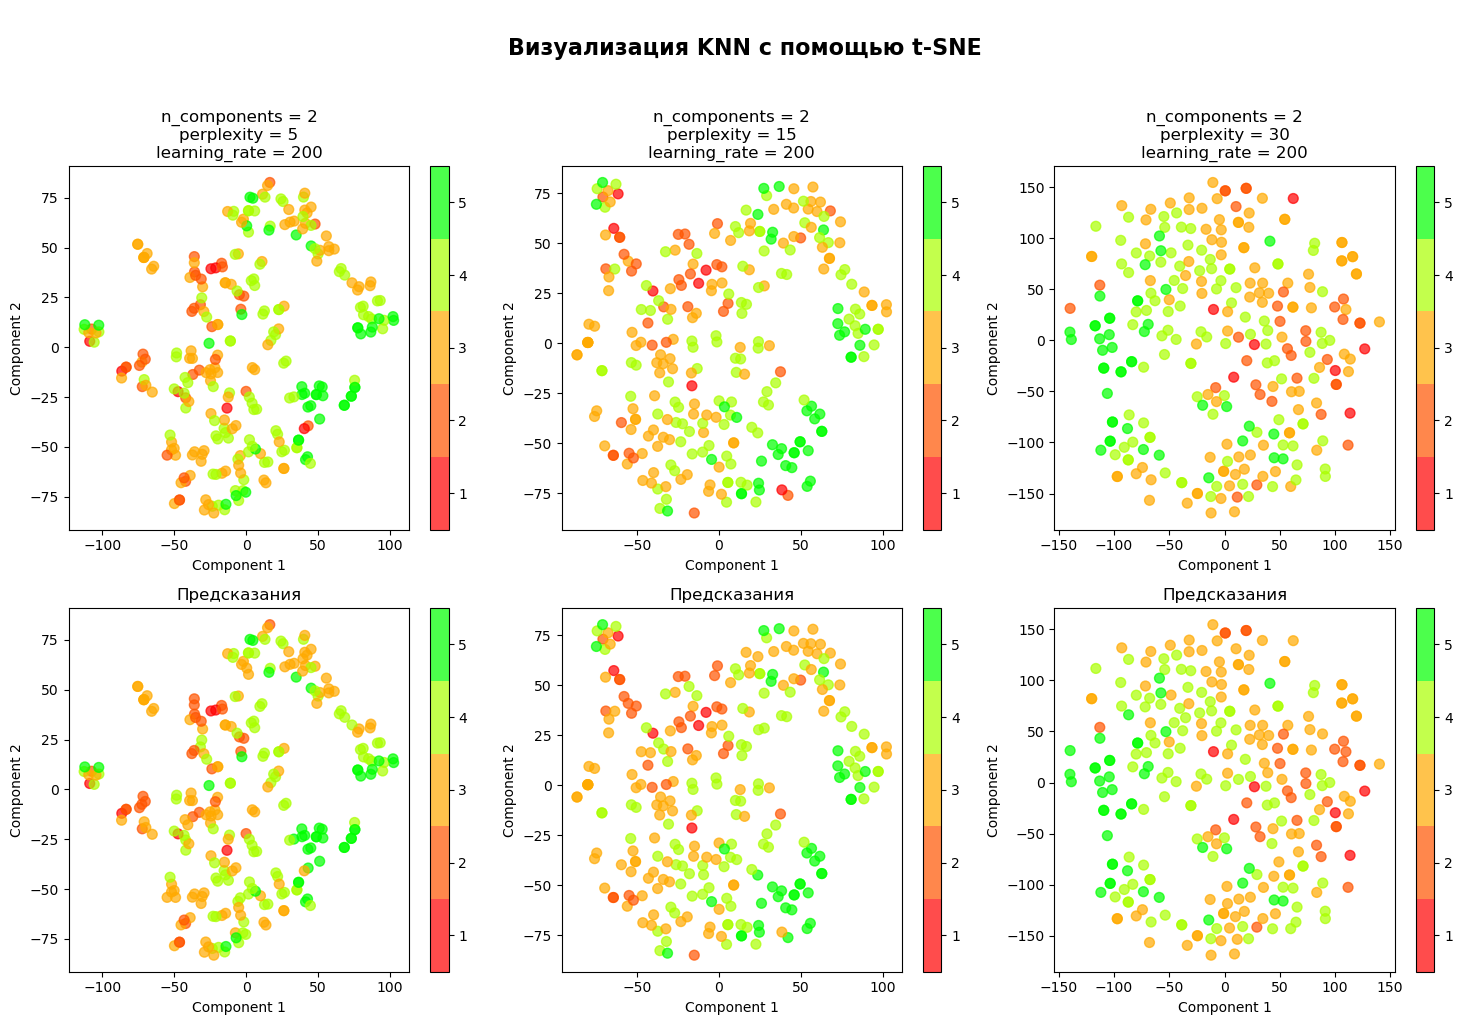

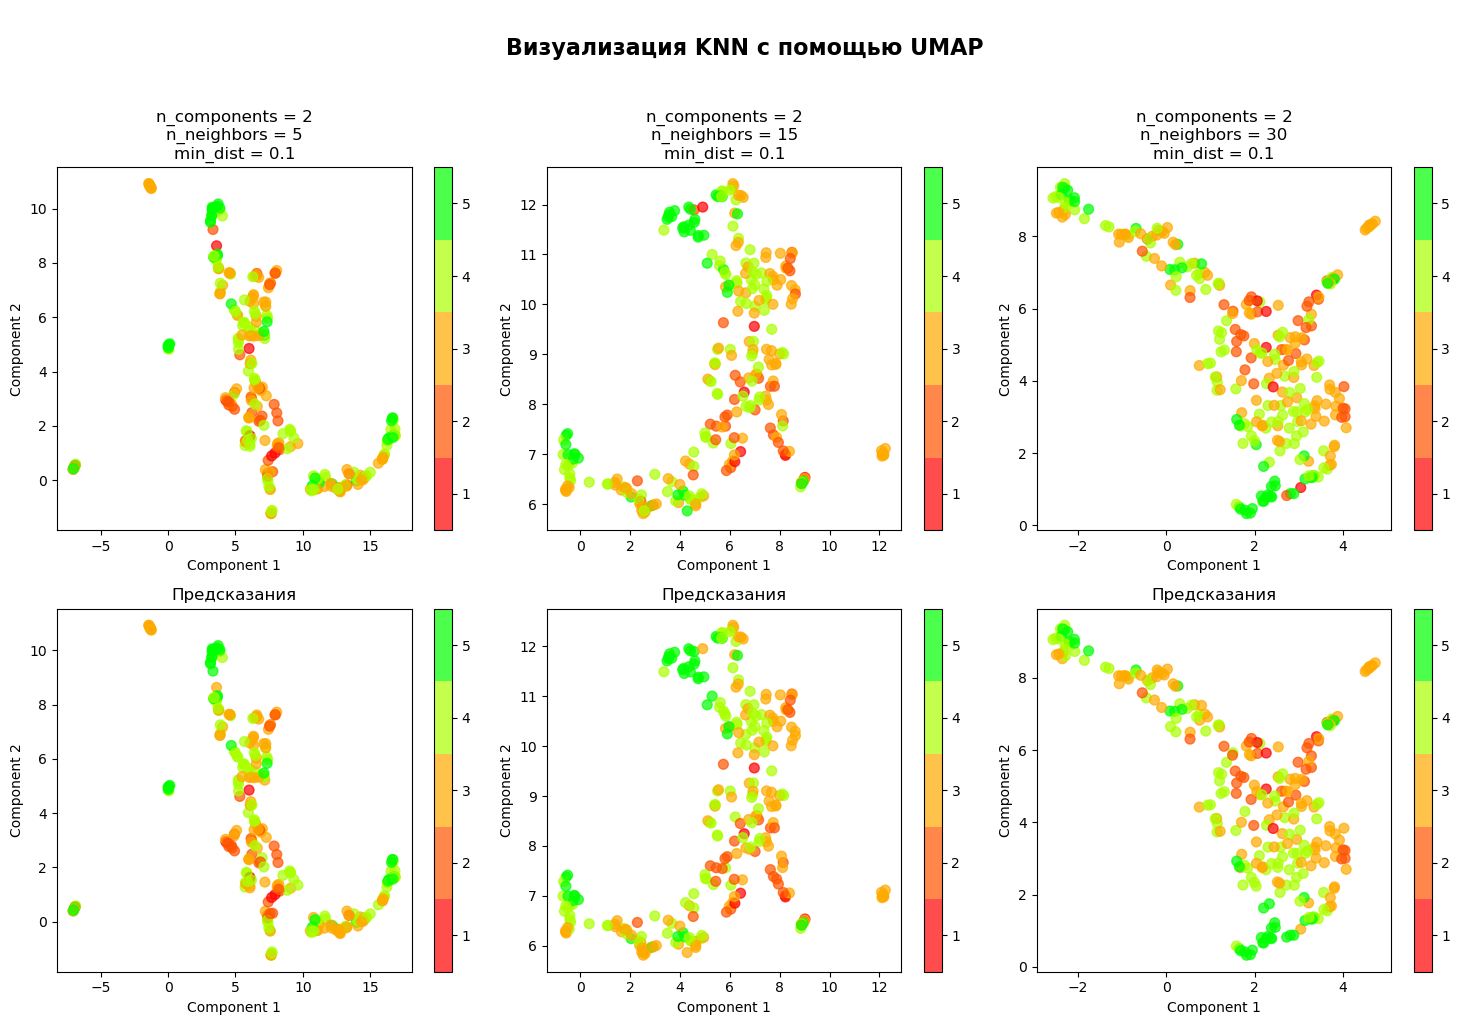

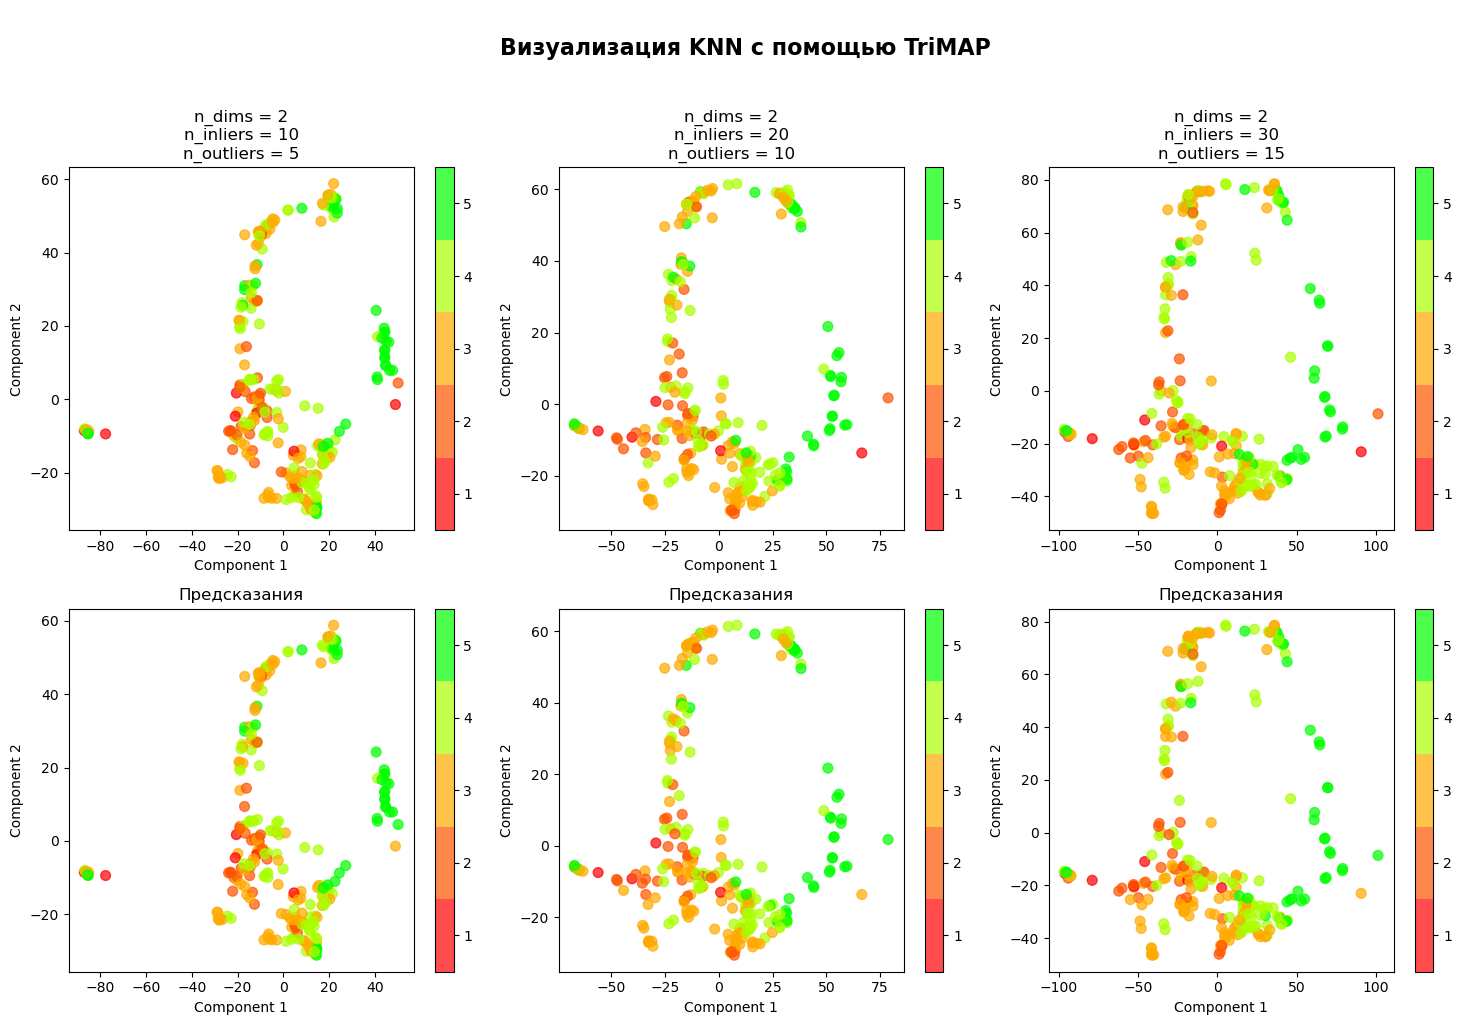

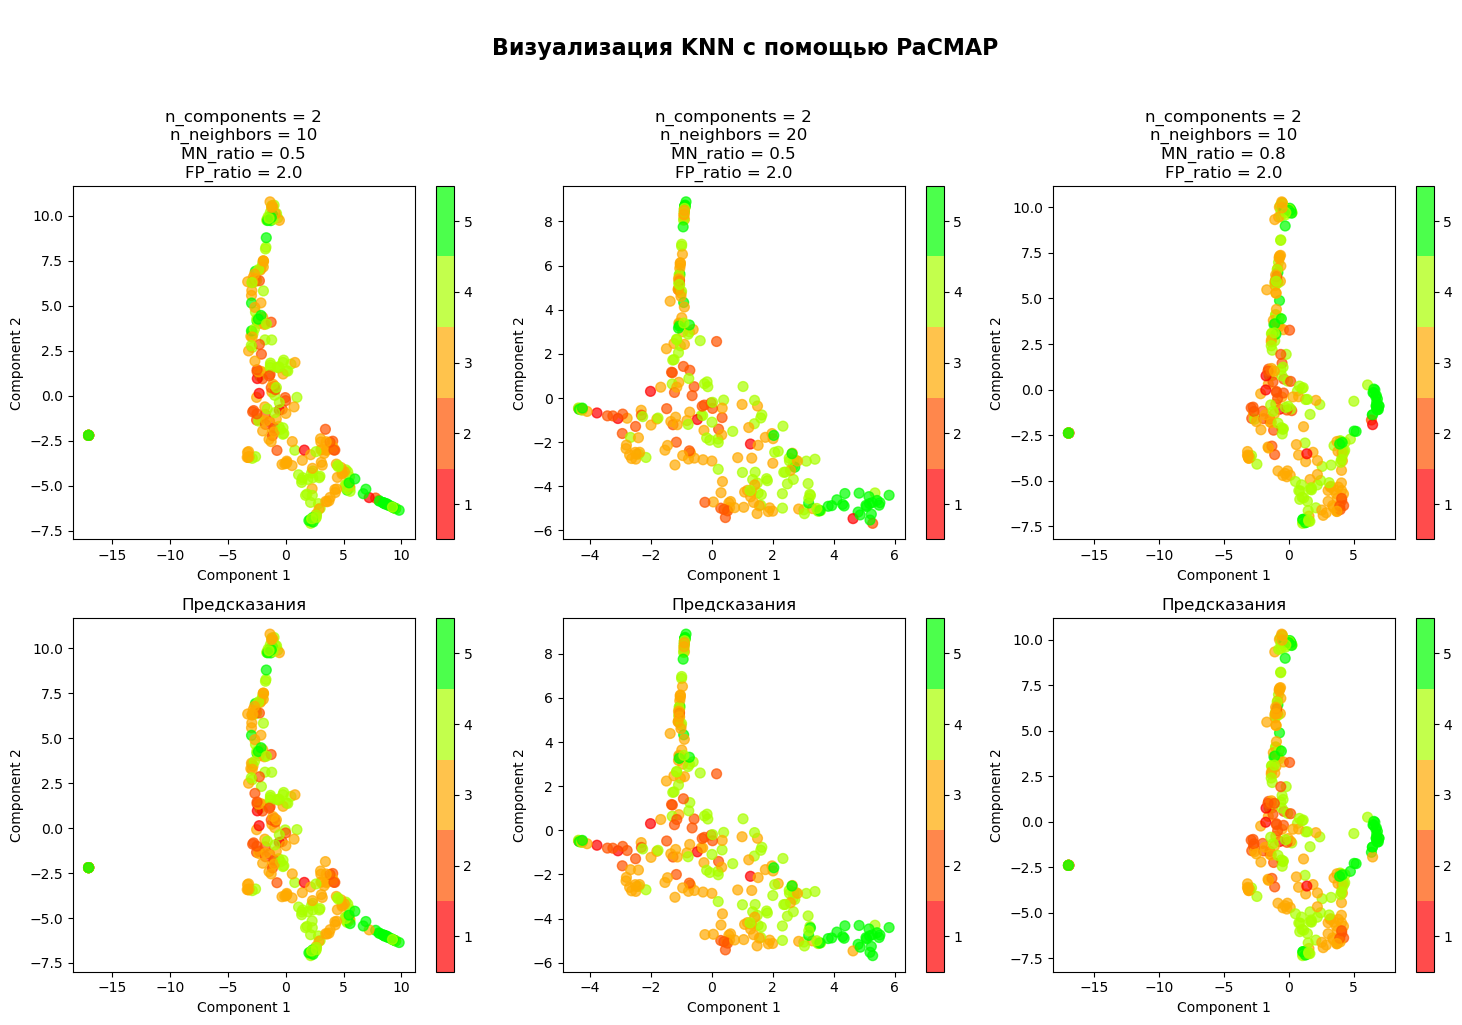

In [14]:
y_all_pred_knn = best_knn.predict(X_scaled)

visualize(X_scaled, y, y_all_pred_knn, "KNN")

## Часть C. Разработать RF-классификатор (Random Forest)

Разбить выборку на обучающую и тестовую. 

Обучить, проверить качество классификатора на обучающей и тестовой выборках: рассчитать общую точность, Recall, Precision, F1-measure. 

Рассмотреть различное число ближайших соседей, различные метрики для вычисления расстояний между объектами, различные правила голосования. Перебор по сетке (grid search). 

Выбрать лучший классификатор. 

Выполнить визуализацию с помощью t-sne, UMAP, TriMAP и PacMAP (при различных сочетаниях значений их параметров): изобразить объекты разных классов разным цветом (разным маркерами). 

Сделать рисунки разбиения на классы на основе выборок с известными метками классов и рисунки разбиения на классы с метками выставленными классификатором. 

Выполнить визуализацию 2 деревьев в случайном лесу, объяснить структуру деревьев и содержимое узлов деревьев. 

In [15]:
param_grid_rf = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [5, 10, 15, 20],
    'min_samples_leaf': [3, 5, 7, 10],
    'max_features': ['sqrt', 'log2', 0.5]
}

rf = RandomForestClassifier(random_state=42)
grid_rf = GridSearchCV(rf, param_grid_rf, cv=3, 
                       scoring='f1_weighted', n_jobs=-1)
grid_rf.fit(X_train, y_train)

best_rf = grid_rf.best_estimator_
print(f"Лучшие параметры Random Forest: {grid_rf.best_params_}")

Лучшие параметры Random Forest: {'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 100}



Оценка на обучающей выборке:
Random Forest Train:
  Accuracy:  0.7964
  Recall:    0.7964
  Precision: 0.7846
  F1-score:  0.7855
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         6
         2.0       0.86      0.69      0.77        26
         3.0       0.73      0.90      0.81        79
         4.0       0.81      0.79      0.80        76
         5.0       0.93      0.79      0.86        34

    accuracy                           0.80       221
   macro avg       0.67      0.63      0.65       221
weighted avg       0.78      0.80      0.79       221



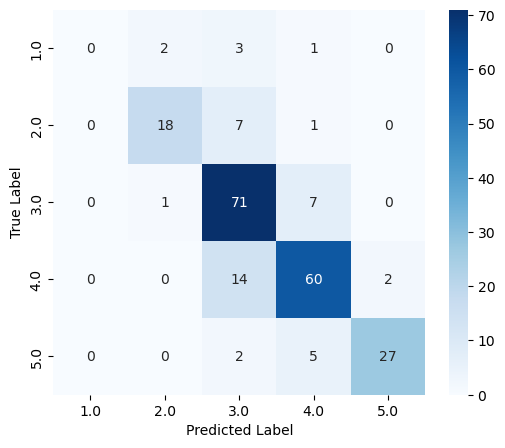


Оценка на тестовой выборке:
Random Forest Test:
  Accuracy:  0.5357
  Recall:    0.5357
  Precision: 0.5383
  F1-score:  0.5176
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         1
         2.0       0.67      0.29      0.40         7
         3.0       0.52      0.75      0.61        20
         4.0       0.53      0.42      0.47        19
         5.0       0.56      0.56      0.56         9

    accuracy                           0.54        56
   macro avg       0.45      0.40      0.41        56
weighted avg       0.54      0.54      0.52        56



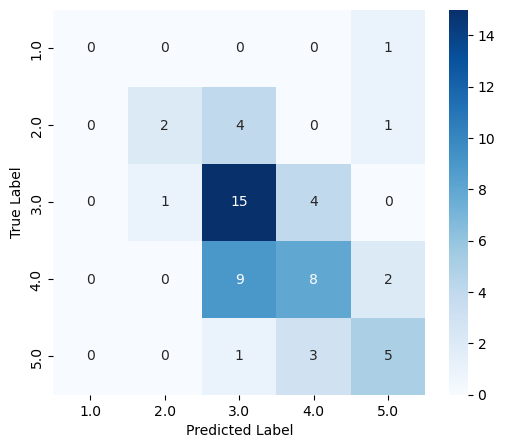

In [16]:
y_train_pred_rf = best_rf.predict(X_train)
print("\nОценка на обучающей выборке:")
train_metrics_rf = evaluate_model(y_train, y_train_pred_rf, "Random Forest Train")

y_test_pred_rf = best_rf.predict(X_test)
print("\nОценка на тестовой выборке:")
test_metrics_rf = evaluate_model(y_test, y_test_pred_rf, "Random Forest Test")

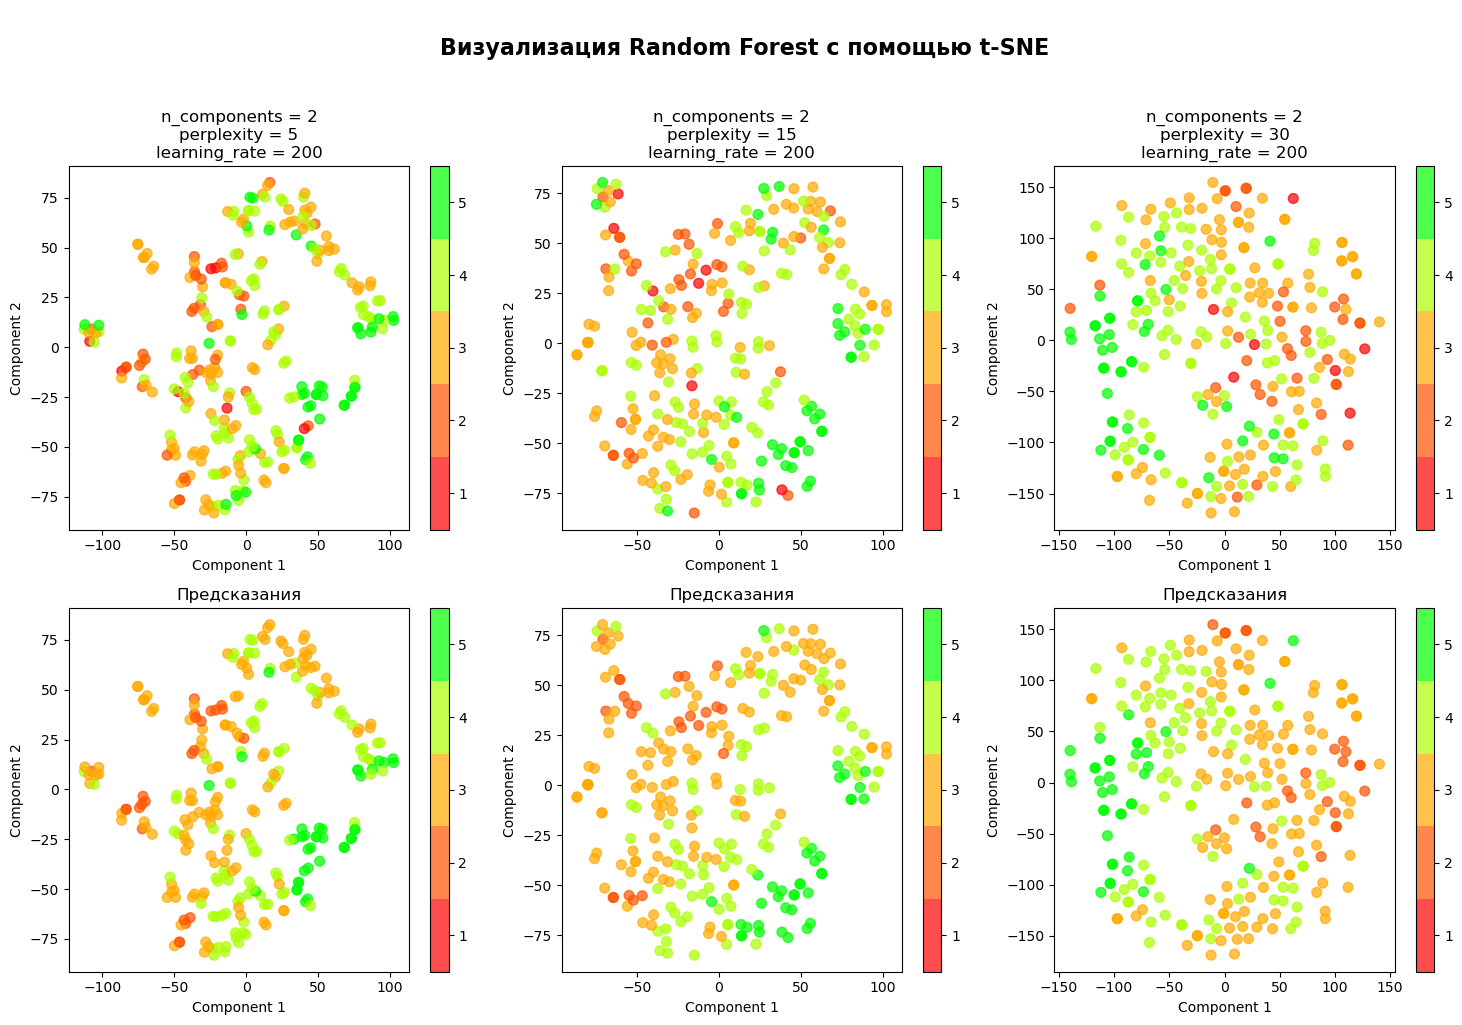

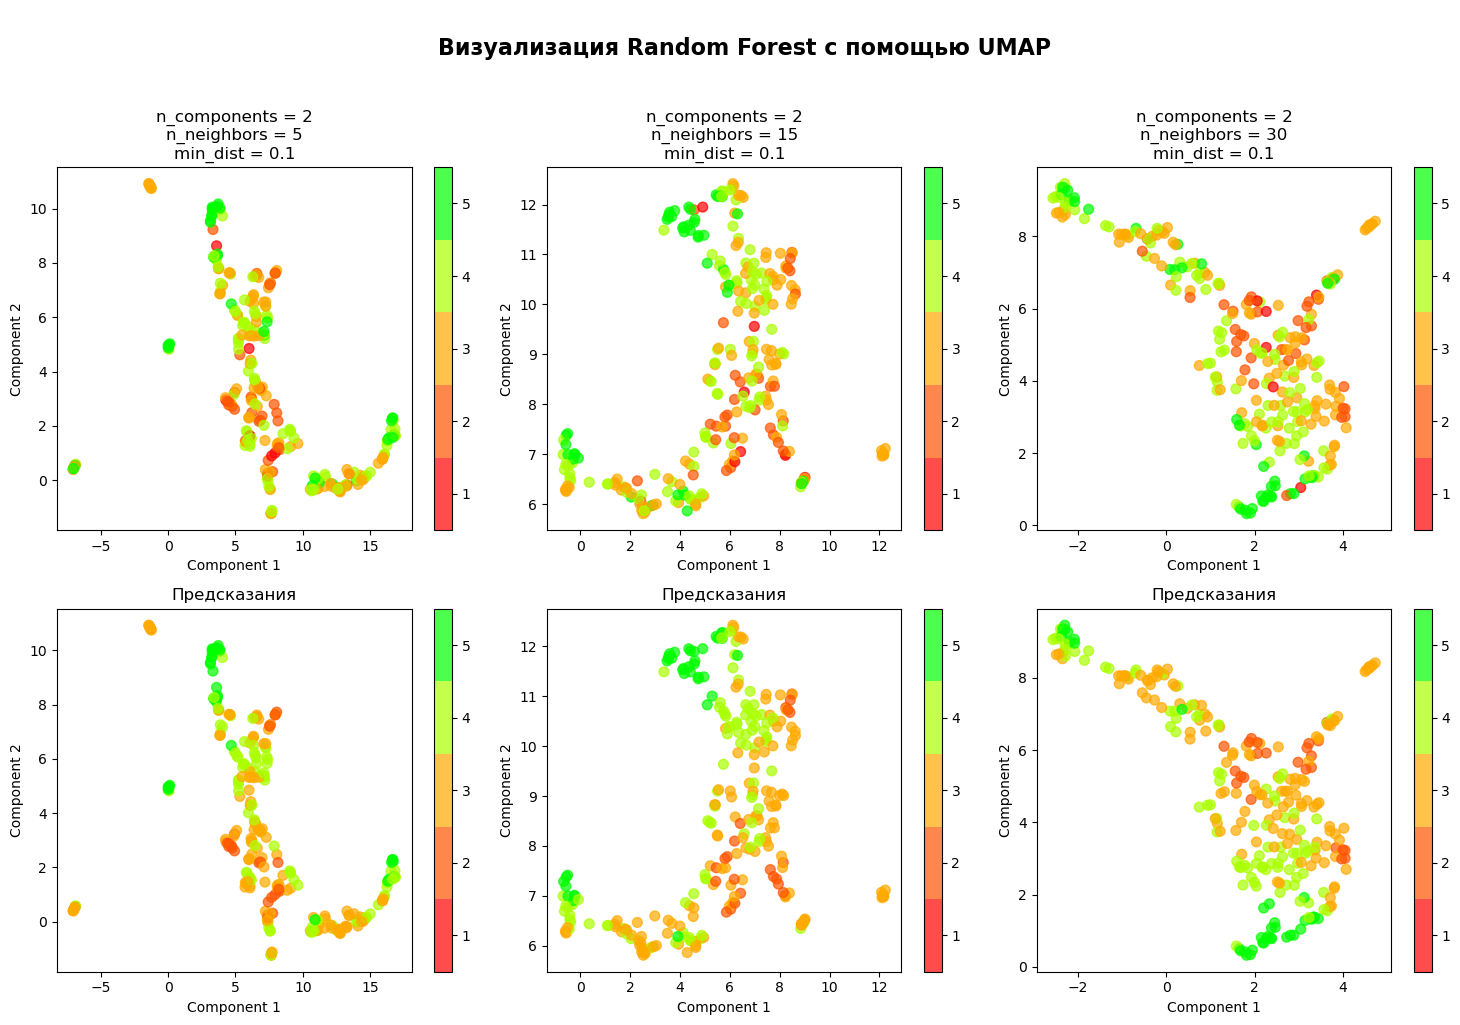

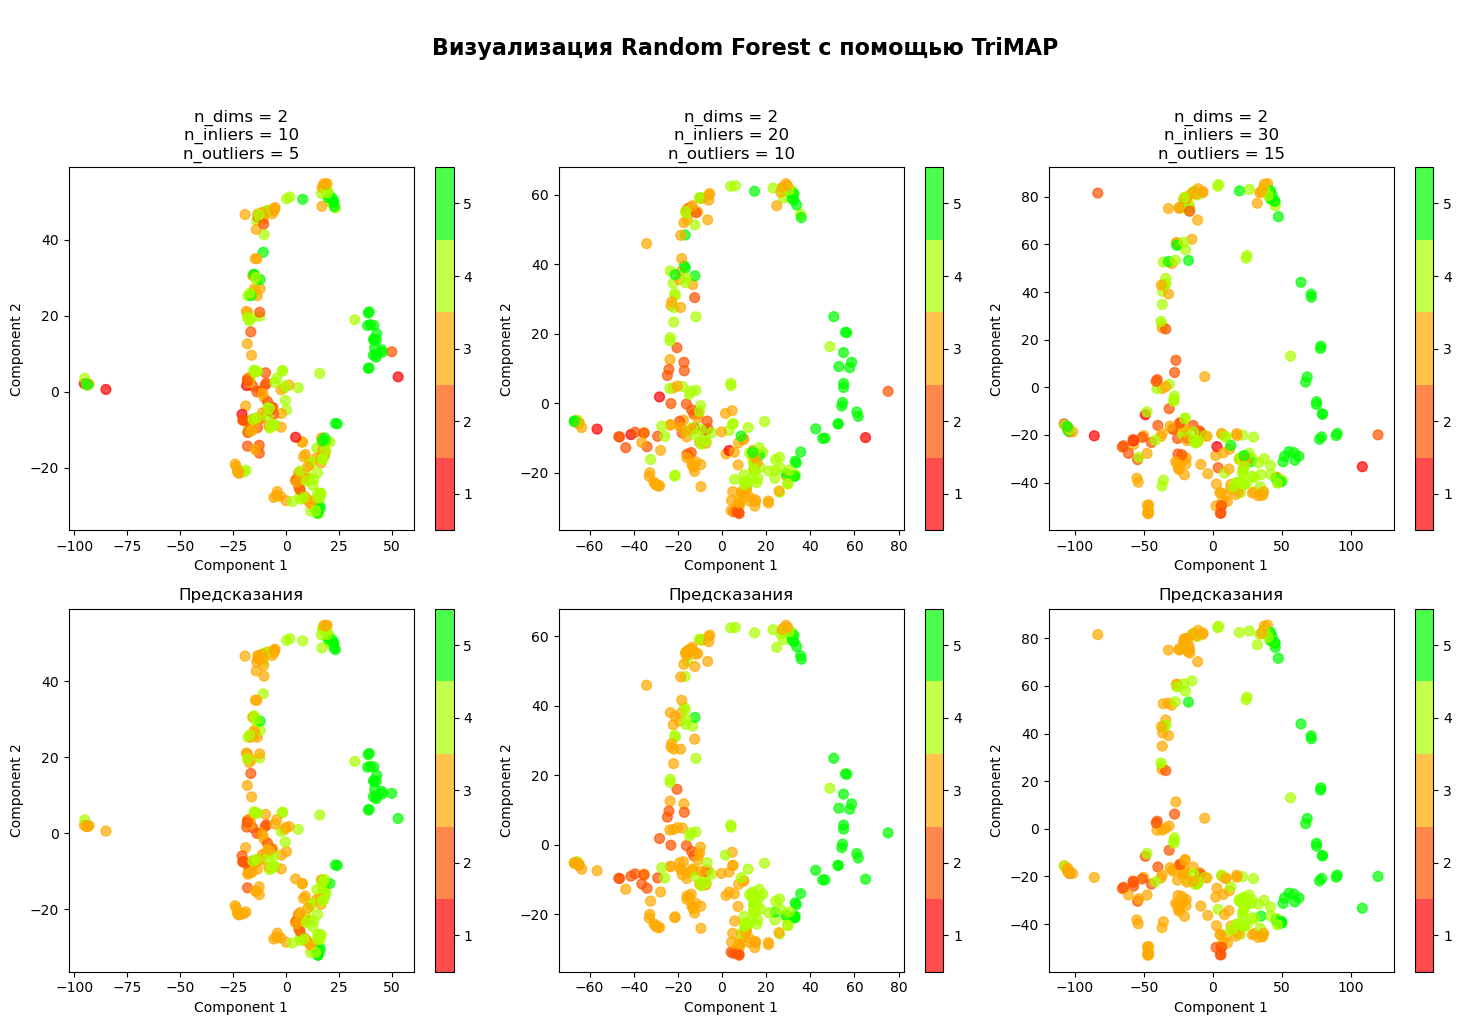

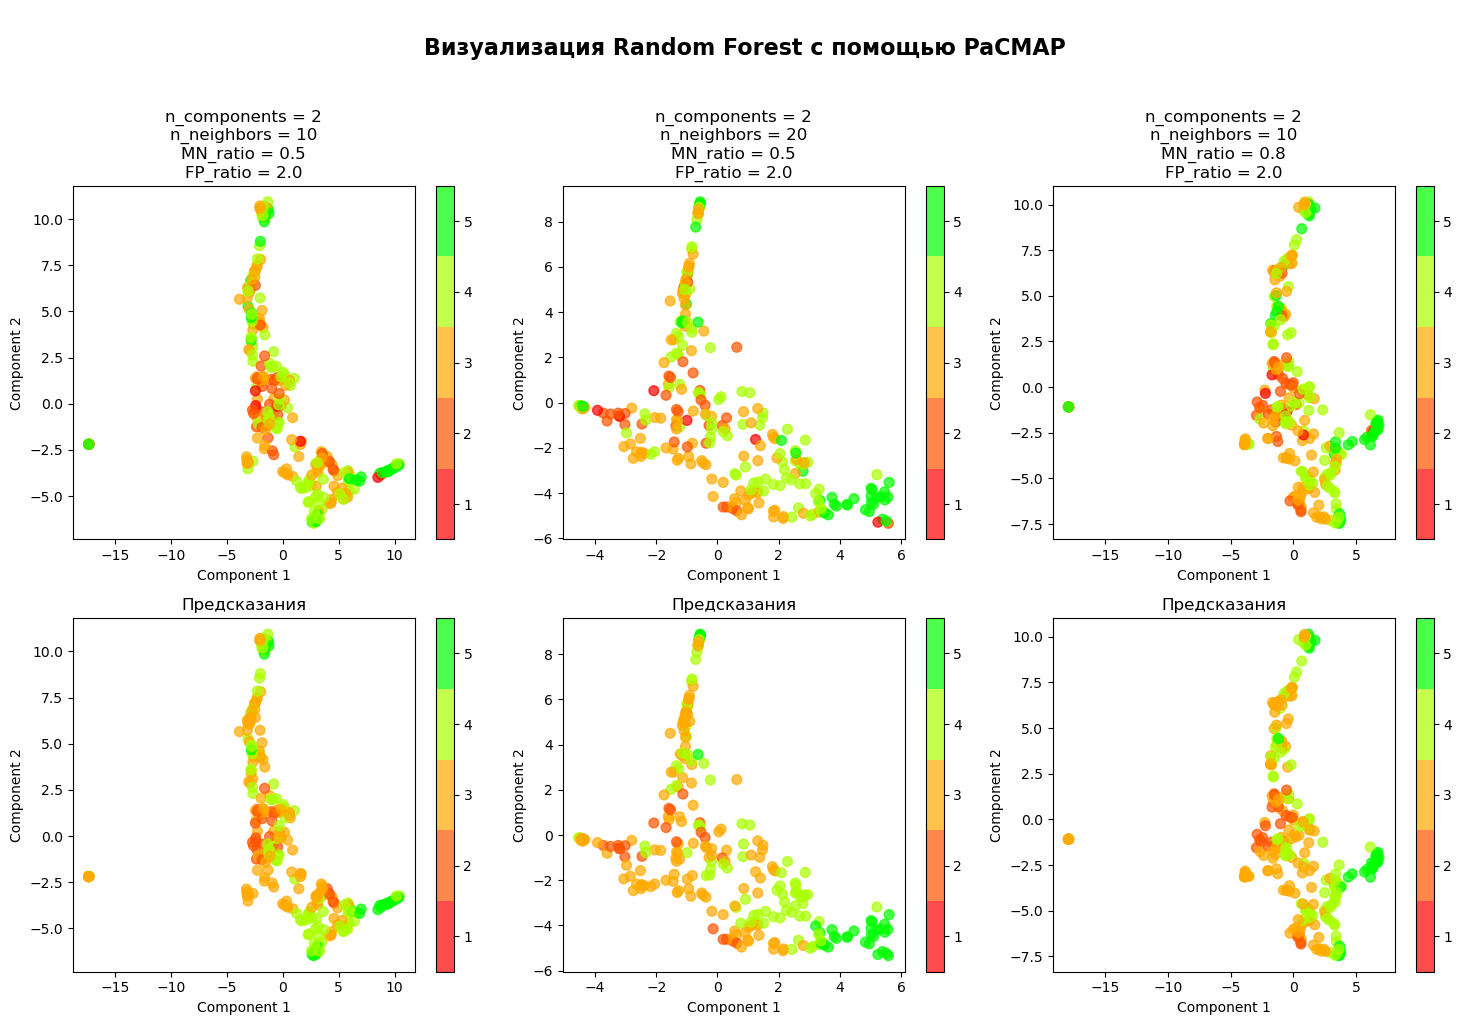

In [17]:
y_all_pred_rf = best_rf.predict(X_scaled)

visualize(X_scaled, y, y_all_pred_rf, "Random Forest")

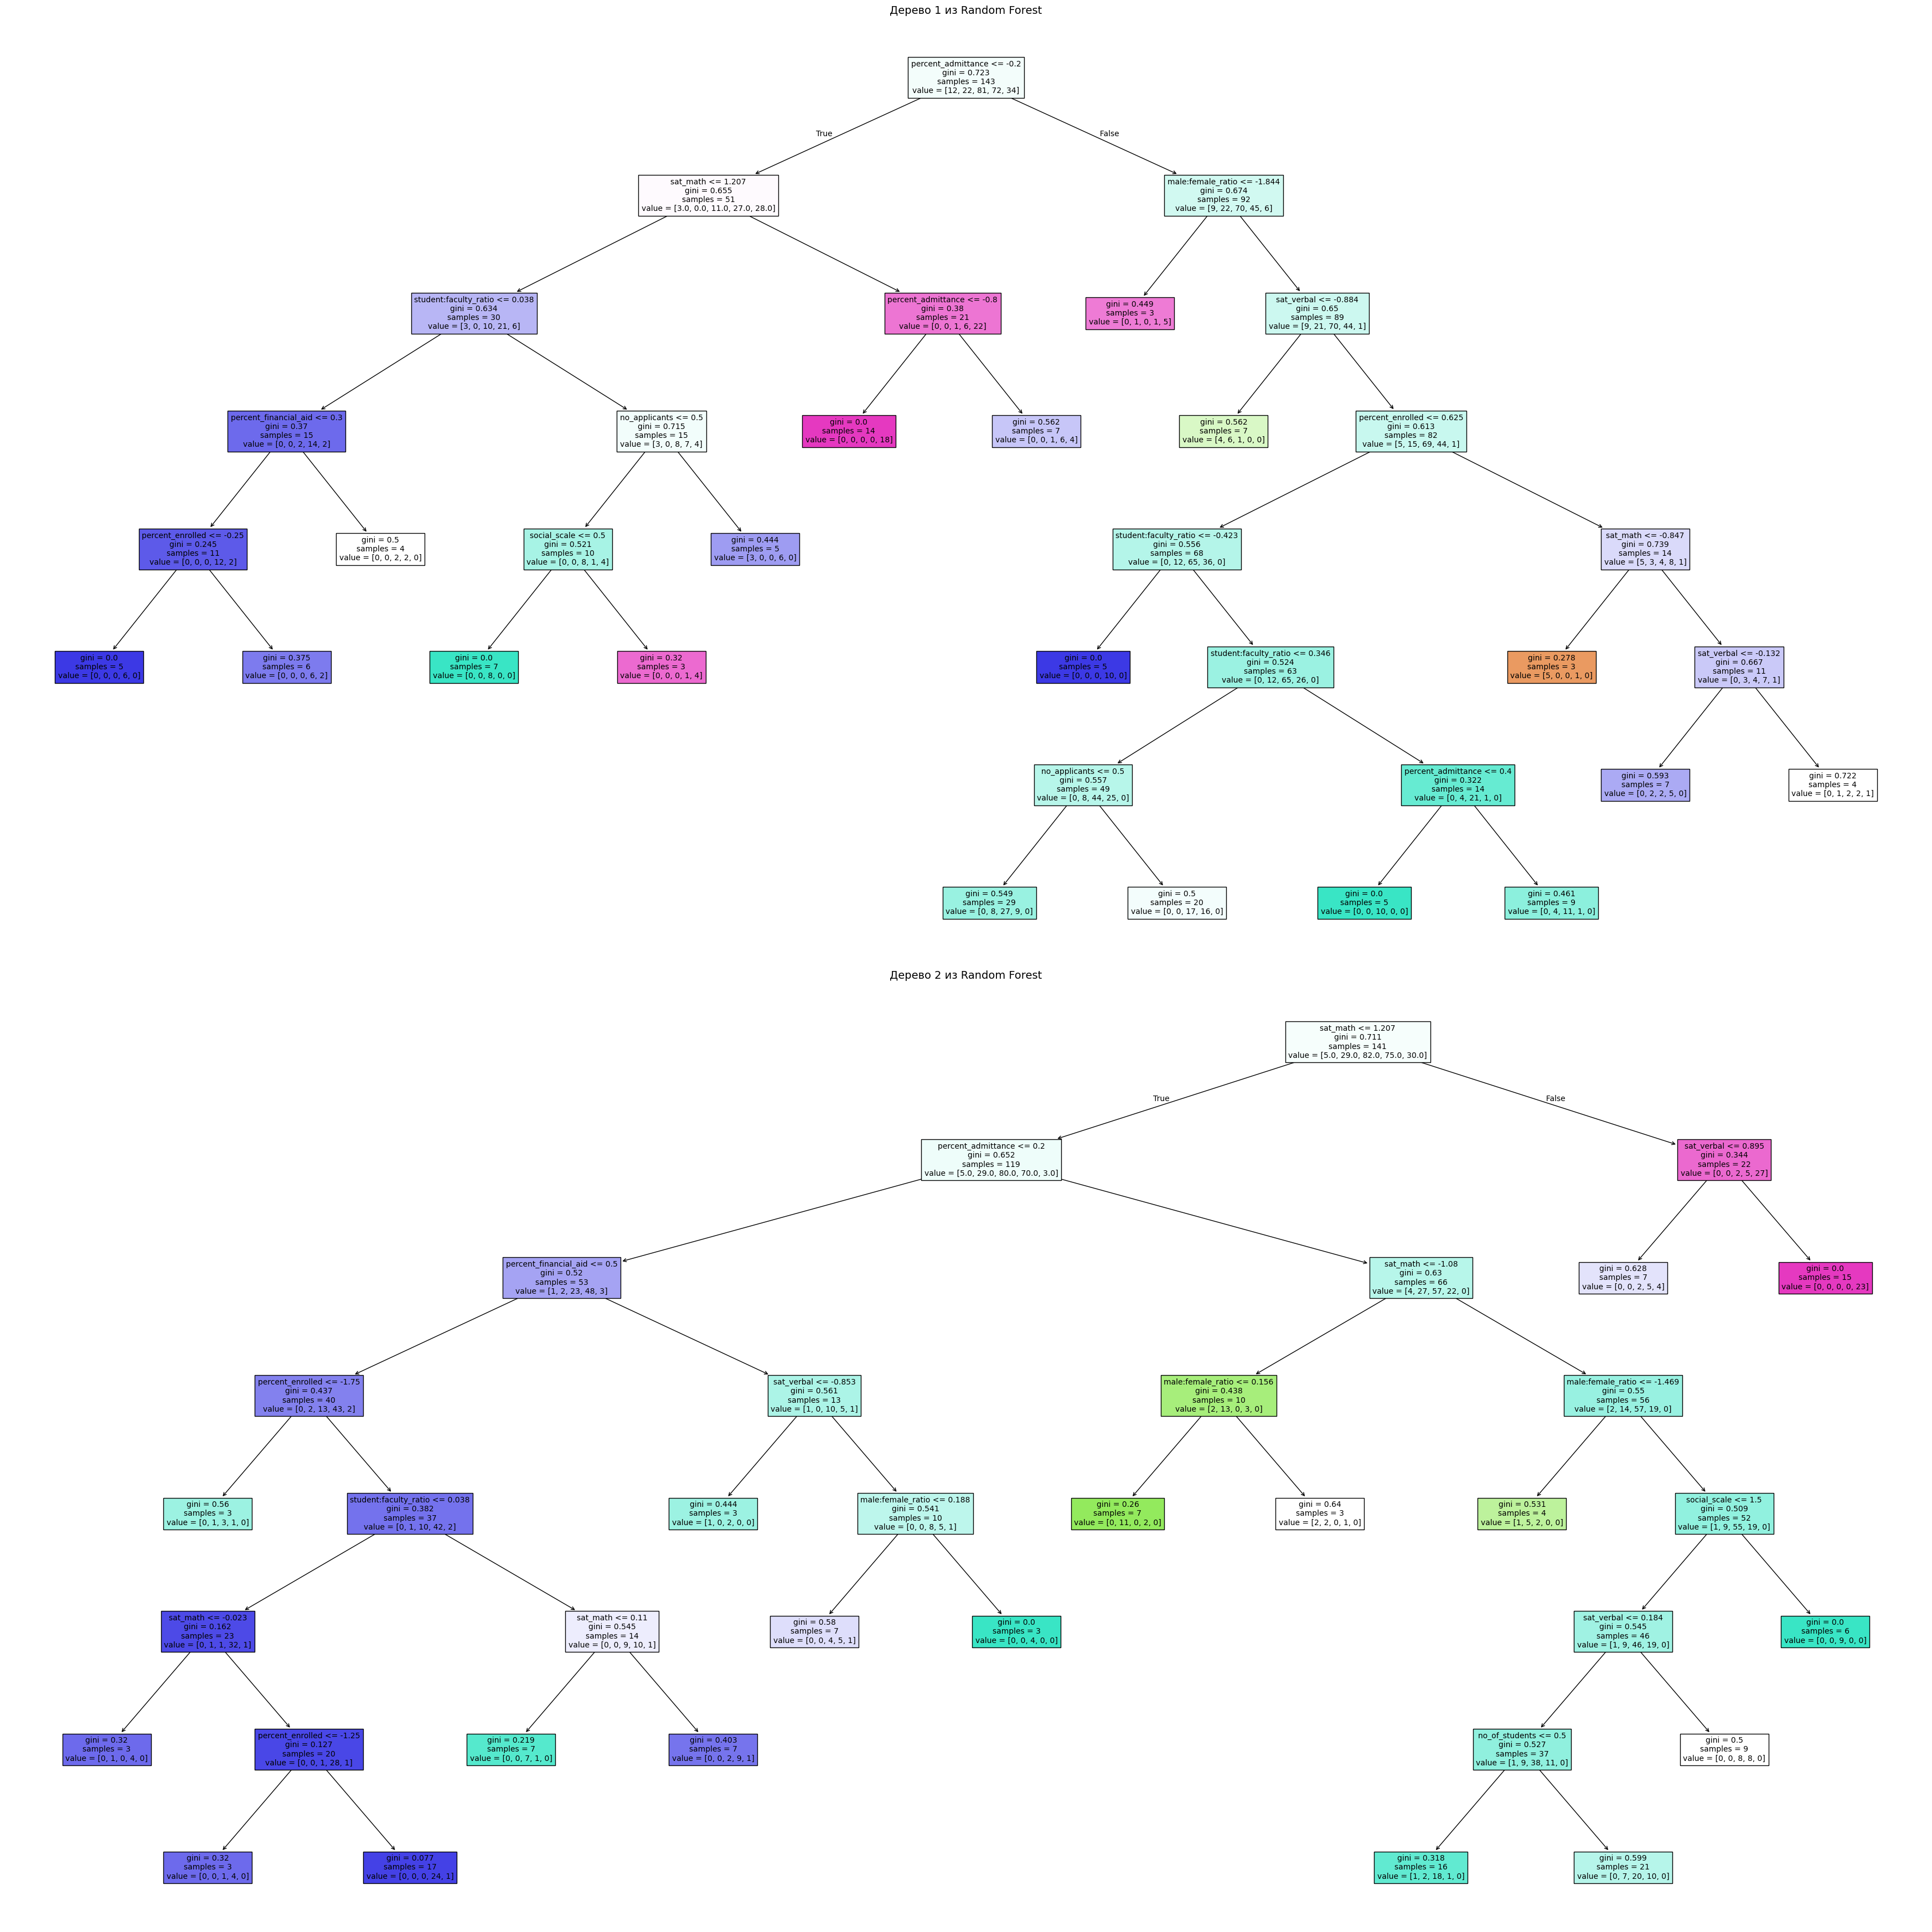

Каждый узел содержит:
 - Условие разделения (признак и порог)
 - Количество образцов в узле (samples)
 - Распределение классов (values)
 - Преобладающий класс (class)
 - Gini impurity (мера неоднородности)


In [18]:
fig, axes = plt.subplots(2, 1, figsize=(35, 35))
for i, ax in enumerate(axes):
    plot_tree(best_rf.estimators_[i], 
              feature_names=X.columns if hasattr(X, 'columns') 
              else [f'Feature {i}' for i in range(X.shape[1])], 
              filled=True, 
              ax=ax, 
#               max_depth=5,
              fontsize=10)
    ax.set_title(f'Дерево {i+1} из Random Forest', fontsize=14)
plt.tight_layout()
plt.show()

print("Каждый узел содержит:")
print(" - Условие разделения (признак и порог)")
print(" - Количество образцов в узле (samples)")
print(" - Распределение классов (values)")
print(" - Преобладающий класс (class)")
print(" - Gini impurity (мера неоднородности)")

In [19]:
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': best_rf.feature_importances_
}).sort_values('importance', ascending=False).head(10)
print(feature_importance)

# plt.figure(figsize=(10, 5))
# plt.barh(feature_importance['feature'], feature_importance['importance'])
# plt.xlabel('Важность признака')
# plt.title('Топ-10 важных признаков (Random Forest)')
# plt.gca().invert_yaxis()
# plt.show()

                  feature  importance
4                sat_math    0.234044
3              sat_verbal    0.174069
8      percent_admittance    0.144002
1       male:female_ratio    0.092204
2   student:faculty_ratio    0.079710
9        percent_enrolled    0.054627
11  quality_of_life_scale    0.047482
5                expenses    0.044612
6   percent_financial_aid    0.039895
7           no_applicants    0.036876


## Сравнение моделей

In [20]:
full_comparison_data = {
    'Model': ['SVM Train', 'SVM Test', 
              'KNN Train', 'KNN Test', 
              'Random Forest Train', 'Random Forest Test'],
    'Accuracy': [train_metrics_svm[0], test_metrics_svm[0], 
                 train_metrics_knn[0], test_metrics_knn[0], 
                 train_metrics_rf[0], test_metrics_rf[0]],
    'Recall': [train_metrics_svm[1], test_metrics_svm[1], 
               train_metrics_knn[1], test_metrics_knn[1], 
               train_metrics_rf[1], test_metrics_rf[1]],
    'Precision': [train_metrics_svm[2], test_metrics_svm[2], 
                  train_metrics_knn[2], test_metrics_knn[2], 
                  train_metrics_rf[2], test_metrics_rf[2]],
    'F1-Score': [train_metrics_svm[3], test_metrics_svm[3], 
                 train_metrics_knn[3], test_metrics_knn[3], 
                 train_metrics_rf[3], test_metrics_rf[3]]
}
full_comparison = pd.DataFrame(full_comparison_data)

full_comparison

Model  Accuracy    Recall  Precision  F1-Score
0            SVM Train  0.651584  0.651584   0.655164  0.651497
1             SVM Test  0.464286  0.464286   0.458684  0.451543
2            KNN Train  1.000000  1.000000   1.000000  1.000000
3             KNN Test  0.642857  0.642857   0.627976  0.628627
4  Random Forest Train  0.796380  0.796380   0.784558  0.785504
5   Random Forest Test  0.535714  0.535714   0.538300  0.517608

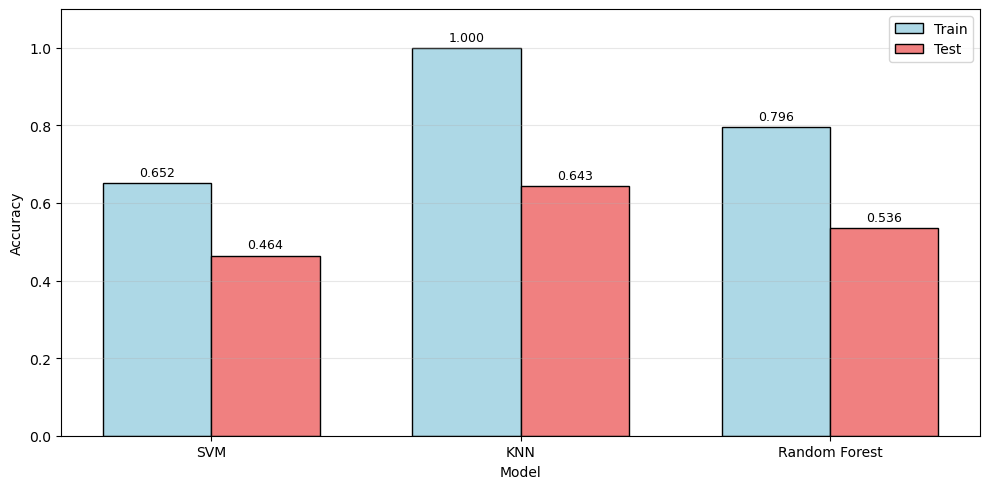

In [21]:
data = {
    'Model': ['SVM', 'KNN', 'Random Forest'],
    'Train': [train_metrics_svm[0], train_metrics_knn[0], train_metrics_rf[0]],
    'Test': [test_metrics_svm[0], test_metrics_knn[0], test_metrics_rf[0]]
}
df = pd.DataFrame(data)

x = np.arange(len(df['Model']))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 5))
bars1 = ax.bar(x - width/2, df['Train'], width, label='Train', 
               color='lightblue', edgecolor='black')
bars2 = ax.bar(x + width/2, df['Test'], width, label='Test', 
               color='lightcoral', edgecolor='black')

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

ax.set_xlabel('Model')
ax.set_ylabel('Accuracy')
ax.set_xticks(x)
ax.set_xticklabels(df['Model'])
ax.legend()
ax.set_ylim(0, 1.1)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()